In [7]:
!pip install tweet-preprocessor

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
import pandas as pd
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import preprocessor as p
from nltk.tokenize import word_tokenize 
from numpy import save
from sklearn import preprocessing

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
train_path = '/content/drive/My Drive/AAAI CONSTRAINT/Fake News/Constraint_English_Train - Sheet1.csv'
val_path = '/content/drive/My Drive/AAAI CONSTRAINT/Fake News/Constraint_English_Val - Sheet1.csv'

In [11]:
train_df = pd.read_csv(train_path)
print(len(train_df))
train_df.head()

6420


,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [12]:
val_df = pd.read_csv(val_path)
print(len(val_df))
val_df.head()

2140


,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [13]:
# Function for Substituting Contractions

def subst(s):
    s = s.replace('theres','there is')
    s = s.replace('didnt','did not')
    s = s.replace("didn't",'did not')
    s = s.replace('havent','have not')
    s = s.replace("aren't",'are not')
    s = s.replace("haven't",'have not')
    s = s.replace('hasnt','has not')
    s = s.replace("hasn't",'has not')
    s = s.replace('couldnt','could not')
    s = s.replace("couldn't",'could not')
    s = s.replace("We'd ",'We would ')
    s = s.replace("we'd ",'we would ')
    s = s.replace("I'd",'I would')
    s = s.replace('cant','can not')
    s = s.replace("can't", 'can not')
    s = s.replace('cannot','can not')
    s = s.replace('Im ','I am ')
    s = s.replace("I've ",'I have ')
    s = s.replace("i've ",'I have ')
    s = s.replace("I'm ",'I am ')
    s = s.replace("isnt",'Is not')
    s = s.replace("isn't",'Is not')    
    s = s.replace('wont','will not')
    s = s.replace("won't",'will not')
    s = s.replace('dont','do not')
    s = s.replace("don't",'do not')
    s = s.replace('doesnt','does not')
    s = s.replace("doesn't",'does not')
    return s

In [15]:
# Substituting Contractions
tweets = train_df.tweet.values
val_tweets = val_df.tweet.values
# print(tweets)
for i in range(len(tweets)):
  if tweets[i]:
    tweets[i] = subst(tweets[i])
for i in range(len(val_tweets)):
  val_tweets[i] = subst(val_tweets[i])


In [16]:
# Running Tweets through Tweet Preprocessor to substitute tags with MENTION, NUMBER, URL, EMOJI,... etc

clean_tweets = [p.tokenize(tweet) for tweet in tweets ]
clean_tweets = [x.replace('$','') for x in clean_tweets]
val_clean_tweets = [p.tokenize(tweet) for tweet in val_tweets ]
val_clean_tweets = [x.replace('$','') for x in val_clean_tweets]
# print(clean_tweets)

tokens = [word_tokenize(tweet) for tweet in clean_tweets]
val_tokens = [word_tokenize(tweet) for tweet in val_clean_tweets]
print(tokens[:20])

[['The', 'CDC', 'currently', 'reports', 'NUMBER', 'deaths', '.', 'In', 'general', 'the', 'discrepancies', 'in', 'death', 'counts', 'between', 'different', 'sources', 'are', 'small', 'and', 'explicable', '.', 'The', 'death', 'toll', 'stands', 'at', 'roughly', 'NUMBER', 'people', 'today', '.'], ['States', 'reported', 'NUMBER', 'deaths', 'a', 'small', 'rise', 'from', 'last', 'Tuesday', '.', 'Southern', 'states', 'reported', 'NUMBER', 'of', 'those', 'deaths', '.', 'URL'], ['Politically', 'Correct', 'Woman', '(', 'Almost', ')', 'Uses', 'Pandemic', 'as', 'Excuse', 'Not', 'to', 'Reuse', 'Plastic', 'Bag', 'URL', 'HASHTAG', 'HASHTAG'], ['HASHTAG', ':', 'We', 'have', 'NUMBER', 'HASHTAG', 'testing', 'laboratories', 'in', 'India', 'and', 'as', 'on', 'NUMBERth', 'August', 'NUMBER', 'NUMBER', 'tests', 'have', 'been', 'done', ':', 'MENTION', 'DG', 'MENTION', 'HASHTAG', 'HASHTAG', 'URL'], ['Populous', 'states', 'can', 'generate', 'large', 'case', 'counts', 'but', 'if', 'you', 'look', 'at', 'the', 'new

In [18]:
len(tokens)

6420

In [19]:
# Creating Labels for train_Y and val_Y
labels = train_df.label.values
val_labels = val_df.label.values
print(labels[:20])
train_Y = []
val_Y = []
for x in labels:
  if x == 'real':
    train_Y.append(1)
  else:
    train_Y.append(0)
for x in val_labels:
  if x == 'real':
    val_Y.append(1)
  else:
    val_Y.append(0)

['real' 'real' 'fake' 'real' 'real' 'real' 'real' 'fake' 'fake' 'fake'
 'real' 'fake' 'real' 'real' 'real' 'real' 'fake' 'real' 'real' 'fake']


In [20]:
# Tags calculated for statistics

data = {}
items = ['URL','MENTION','HASHTAG','RESERVED','EMOJI','SMILEY','NUMBER']
data['0'] = {}
data['1'] = {}
for item in items:
  data['0'][item] = []
  data['1'][item] = []

print()
for i in range(len(clean_tweets)):
  for item in items:
    data[str(train_Y[i])][item].append(clean_tweets[i].count(item))
print(data['0']['HASHTAG'][:100])
print(data['1']['HASHTAG'][:100])

print(np.mean(data['0']['HASHTAG']))
print(len(data['0']['HASHTAG']),len(data['0']['HASHTAG'])-data['0']['HASHTAG'].count(0),len(data['0']['URL'])-data['0']['URL'].count(0),len(data['0']['EMOJI'])-data['0']['EMOJI'].count(0))

print(np.mean(data['1']['HASHTAG']))
print(len(data['1']['HASHTAG']),len(data['1']['HASHTAG'])-data['1']['HASHTAG'].count(0),len(data['1']['URL'])-data['1']['URL'].count(0),len(data['1']['EMOJI'])-data['1']['EMOJI'].count(0))



[2, 0, 0, 0, 0, 0, 0, 1, 1, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0]
[0, 0, 4, 0, 0, 1, 1, 1, 3, 1, 13, 2, 0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 4, 1, 1, 1, 11, 1, 1, 0, 3, 3, 12, 0, 0, 1, 0, 3, 1, 0, 3, 0, 0, 5, 3, 0, 1, 0, 0, 0, 0, 3, 2, 10, 1, 1, 4, 0, 3, 0, 0, 3, 2, 1, 1, 0, 6, 0, 2, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 4, 6, 2, 0, 0, 1, 0, 2, 1, 1]
0.5091503267973856
3060 573 1001 34
1.0738095238095238
3360 1714 2325 272


In [22]:
# Total Stats of Tags
stat = {}
for item in items:
  stat[item] = []

  c0 = [x for x in data['0'][item] if x != 0]
  c1 = [x for x in data['1'][item] if x != 0]
  stat[item].append((len(c0),len
  (data['0'][item]),np.mean(c0)))
  stat[item].append((len(c1),len(data['1'][item]),np.mean(c1)))


print(stat)

{'URL': [(1001, 3060, 1.2527472527472527), (2325, 3360, 1.3505376344086022)], 'MENTION': [(239, 3060, 2.410041841004184), (937, 3360, 1.7107790821771611)], 'HASHTAG': [(573, 3060, 2.719022687609075), (1714, 3360, 2.105017502917153)], 'RESERVED': [(19, 3060, 1.0), (245, 3360, 1.0)], 'EMOJI': [(34, 3060, 2.2058823529411766), (272, 3360, 2.6286764705882355)], 'SMILEY': [(3, 3060, 1.0), (2, 3360, 1.0)], 'NUMBER': [(657, 3060, 1.552511415525114), (1990, 3360, 2.812060301507538)]}


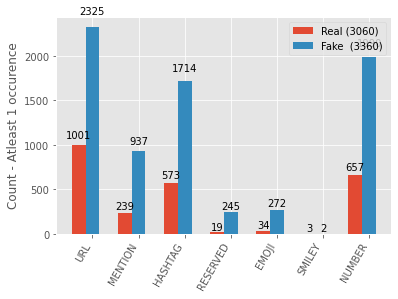

In [23]:
#Graphs for Tags

ind = np.arange(len(stat.keys()))
width = 0.3

fig = plt.figure()
ax = fig.add_subplot(111)


c0 = [stat[i][0][0] for i in stat]
rects1 = ax.bar(ind, c0, width, )

c1 = [stat[i][1][0] for i in stat]
rects2 = ax.bar(ind+width, c1, width, )


ax.set_ylabel('Count - Atleast 1 occurence')
ax.set_xticks(ind+width)

ax.set_xticklabels( tuple(stat.keys()) )
ax.legend( (rects1[0], rects2[0]), ('Real (%d)'%stat['HASHTAG'][0][1],'Fake  (%d)'%stat['HASHTAG'][1][1]) )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)
plt.xticks(rotation=60,ha='right')
plt.show()

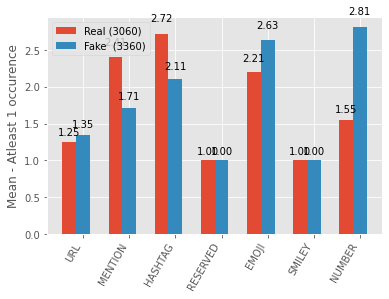

In [24]:
#Graphs for Tags
ind = np.arange(len(stat.keys()))
width = 0.3

fig = plt.figure()
ax = fig.add_subplot(111)


c0 = [stat[i][0][2] for i in stat]
rects1 = ax.bar(ind, c0, width, )

c1 = [stat[i][1][2] for i in stat]
rects2 = ax.bar(ind+width, c1, width, )


ax.set_ylabel('Mean - Atleast 1 occurence')
ax.set_xticks(ind+width)

ax.set_xticklabels( tuple(stat.keys()) )
ax.legend( (rects1[0], rects2[0]), ('Real (%d)'%stat['HASHTAG'][0][1],'Fake  (%d)'%stat['HASHTAG'][1][1]) )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%.2f'%(h),
                ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)
plt.xticks(rotation=60,ha='right')
plt.show()

In [25]:
tuple(stat.keys())

('URL', 'MENTION', 'HASHTAG', 'RESERVED', 'EMOJI', 'SMILEY', 'NUMBER')

In [26]:
# Getting Data

train_X = load('/content/drive/My Drive/Dataset-FakeNews/train_X.npy')
train_X = np.array(train_X)
val_X = load('/content/drive/My Drive/Dataset-FakeNews/val_X.npy')
val_X = np.array(val_X)

In [28]:
# Append Tag info to Input Data 1/2

data = {}
items = ['URL','MENTION','HASHTAG','RESERVED','EMOJI','SMILEY','NUMBER']
for item in items:
  data[item] = []
  data[item] = []

print()
for i in range(len(clean_tweets)):
  for item in items:
    data[item].append(clean_tweets[i].count(item))


print(len(data['HASHTAG']))
# print(data)

arr = []

for item in items:
  arr.append(data[item])

arr = np.array(arr)
arr = arr.T
print(arr.shape)


6420
(6420, 7)


In [29]:
# Append Tag info to Input Data 2/2
print(train_X.shape)
print(arr.shape)
train_X_new = np.concatenate((train_X,arr),axis=1)
print(train_X_new.shape)
print(train_X_new.T[300][:100])


(6420, 300)
(6420, 7)
(6420, 307)
[0. 1. 1. 1. 1. 1. 2. 1. 0. 1. 2. 2. 2. 0. 2. 1. 0. 0. 2. 0. 2. 0. 0. 0.
 1. 1. 0. 0. 0. 2. 2. 0. 2. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 2. 1. 1. 1. 0.
 0. 1. 2. 1. 1. 0. 0. 1. 0. 1. 2. 0. 2. 2. 0. 0. 1. 0. 0. 0. 1. 0. 0. 2.
 1. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 2. 0. 1. 0. 0.
 1. 0. 0. 0.]


In [30]:
# Append Tag info to Input Data 1/2
val_data = {}
items = ['URL','MENTION','HASHTAG','RESERVED','EMOJI','SMILEY','NUMBER']
for item in items:
  val_data[item] = []
  val_data[item] = []

print()
for i in range(len(val_clean_tweets)):
  for item in items:
    val_data[item].append(val_clean_tweets[i].count(item))


print(len(val_data['HASHTAG']))
# print(val_data)

val_arr = []

for item in items:
  val_arr.append(val_data[item])

val_arr = np.array(val_arr)
val_arr = val_arr.T
print(val_arr.shape)


2140
(2140, 7)


In [31]:
# Append Tag info to Input Data 2/2
print(val_X.shape)
print(val_arr.shape)
val_X_new = np.concatenate((val_X,val_arr),axis=1)
print(val_X_new.shape)
print(val_X_new.T[300][:100])


(2140, 300)
(2140, 7)
(2140, 307)
[0. 0. 0. 2. 2. 0. 1. 0. 0. 0. 1. 1. 1. 0. 2. 2. 0. 0. 0. 0. 2. 1. 0. 2.
 1. 1. 0. 1. 2. 2. 0. 1. 0. 0. 2. 0. 0. 2. 0. 2. 1. 1. 2. 0. 0. 1. 1. 0.
 0. 2. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 2. 1. 1. 2. 1. 1. 0. 0. 2. 0. 0.
 0. 2. 2. 2. 0. 2. 0. 0. 0. 0. 1. 0. 1. 2. 2. 0. 1. 1. 2. 0. 0. 0. 2. 0.
 0. 1. 2. 0.]


In [ ]:
# Saving the New Input Data
from numpy import save

save('train_X_new.npy', train_X_new)
save('val_X_new.npy', val_X_new)

In [32]:
import seaborn as sns

Train:
mean =  181.67866043613708
std  =  150.63387980132478
[525, 545, 545, 581, 695, 880, 925, 2086, 5046, 8851]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


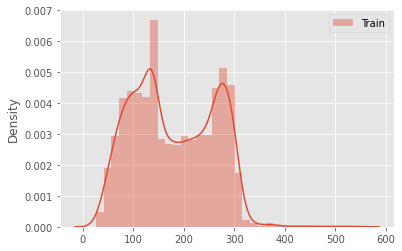

In [33]:
# Experiments with Length of Tweet

tweets = train_df['tweet']
train_len_arr = []
for tweet in tweets:
  train_len_arr.append(len(tweet))


print("Train:")
print("mean = ",np.mean(train_len_arr))
print("std  = ",np.std(train_len_arr))
x = train_len_arr.copy()
x.sort()
print(x[-10:])

sns.distplot(x[8:-8], hist=True,label="Train")
plt.legend(loc="upper right")
plt.show()

Val:
mean =  179.71308411214955
std  =  91.71451498379388
[349, 364, 419, 445, 465, 520, 520, 633, 723, 2136]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


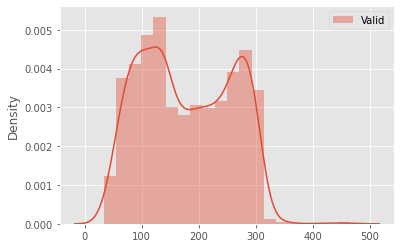

In [34]:
# Experiments with Length of Tweet
tweets = val_df['tweet']
len_arr = []
for tweet in tweets:
  len_arr.append(len(tweet))

print("Val:")
print("mean = ",np.mean(len_arr))
print("std  = ",np.std(len_arr))

x = len_arr.copy()
x.sort()
print(x[-10:])
sns.distplot(x[5:-5], hist=True,label="Valid")
plt.legend(loc="upper right")
plt.show()

In [35]:
x = [1,2,3,4,5,6,7,8,9,10]
print(np.quantile(x,2/3))

7.0


In [36]:
train_X = load('/content/drive/My Drive/Dataset-FakeNews/train_X.npy')
train_X_new = load('/content/drive/My Drive/Dataset-FakeNews/train_X_new.npy')
train_Y = load('/content/drive/My Drive/Dataset-FakeNews/train_Y.npy')
val_X = load('/content/drive/My Drive/Dataset-FakeNews/val_X.npy')
val_X_new = load('/content/drive/My Drive/Dataset-FakeNews/val_X_new.npy')
val_Y = load('/content/drive/My Drive/Dataset-FakeNews/val_Y.npy')

In [37]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train_X_new, train_Y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [38]:
def print_metrices(pred,true):
    # print(confusion_matrix(true,pred))
    # print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [39]:
print("Train Accuracy = ",clf.score(train_X_new,train_Y))
print("Val Accuracy = ", clf.score(val_X_new,val_Y))

Train Accuracy =  0.9758566978193146
Val Accuracy =  0.9355140186915888


In [40]:
# pred_train = clf.predict(train_X_new)
pred = clf.predict(val_X_new)
y_true = train_Y


In [41]:

y_true = val_Y
y_pred = pred
target_names = ['Real','Fake']
print(classification_report(y_true, y_pred, target_names=target_names))

print_metrices(y_pred,y_true)

              precision    recall  f1-score   support

        Real       0.93      0.93      0.93      1020
        Fake       0.94      0.94      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140

Accuracy :  0.9355140186915888
Precison :  0.9355214141731458
Recall :  0.9355140186915888
F1 :  0.9355168977845817


In [42]:
# Experiments with Quantiles
no_of_quantiles = 3
q_true = [ [] for x in range(no_of_quantiles) ]
q_pred = [ [] for x in range(no_of_quantiles) ]



for i in range(len(len_arr)):
  if len_arr[i] < np.quantile(len_arr,1/3):
    q_true[0].append(y_true[i])
    q_pred[0].append(pred[i])
  elif len_arr[i] < np.quantile(len_arr,2/3):
    q_true[1].append(y_true[i])
    q_pred[1].append(pred[i])
  else:
    q_true[2].append(y_true[i])
    q_pred[2].append(pred[i])


In [43]:
from sklearn.metrics import classification_report
for i in range(no_of_quantiles):
  y_true = q_true[i]
  y_pred = q_pred[i]
  target_names = ['Real'+str(i),'Fake'+str(i)]
  print(classification_report(y_true, y_pred, target_names=target_names))
  print_metrices(y_pred,y_true)

              precision    recall  f1-score   support

       Real0       0.96      0.98      0.97       574
       Fake0       0.90      0.82      0.86       139

    accuracy                           0.95       713
   macro avg       0.93      0.90      0.91       713
weighted avg       0.95      0.95      0.95       713

Accuracy :  0.9481065918653576
Precison :  0.9510047019536024
Recall :  0.9481065918653576
F1 :  0.9490889174759282
              precision    recall  f1-score   support

       Real1       0.91      0.93      0.92       289
       Fake1       0.95      0.93      0.94       424

    accuracy                           0.93       713
   macro avg       0.93      0.93      0.93       713
weighted avg       0.93      0.93      0.93       713

Accuracy :  0.9326788218793829
Precison :  0.9326432940656373
Recall :  0.9326788218793829
F1 :  0.9325398686919733
              precision    recall  f1-score   support

       Real2       0.89      0.76      0.82       157
     

In [44]:
# Experiments with Quantiles
a = [[1,2],[3,4],[5,6],[7,8]]
b = [9,10,11,12]
print(np.array(a).shape)
print(np.array(b).shape)
c = [a[i] + [b[i]] for i in range(len(a))]
print(c)
print(np.array(c).shape)

(4, 2)
(4,)
[[1, 2, 9], [3, 4, 10], [5, 6, 11], [7, 8, 12]]
(4, 3)


In [45]:
a = list(train_X_new)
b = list(train_len_arr)
print(np.array(a).shape)
print(np.array(b).shape)
c = [list(a[i]) + [b[i]] for i in range(len(a))]
# print(c)
train_X_newer = c

(6420, 307)
(6420,)


In [46]:
a = list(val_X_new)
b = list(len_arr)
print(np.array(a).shape)
print(np.array(b).shape)
c = [list(a[i]) + [b[i]] for i in range(len(a))]
# print(c)
val_X_newer = c

(2140, 307)
(2140,)


In [47]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(train_X_new, train_Y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [48]:
print("Train Accuracy = ",clf.score(train_X_new,train_Y))
print("Val Accuracy = ", clf.score(val_X_new,val_Y))

Train Accuracy =  0.9758566978193146
Val Accuracy =  0.9355140186915888


In [49]:
# pred_train = clf.predict(train_X_new)
pred = clf.predict(val_X_new)
y_true = val_Y


In [50]:

y_true = val_Y
y_pred = pred
target_names = ['Real','Fake']
print(classification_report(y_true, y_pred, target_names=target_names))

print_metrices(y_pred,y_true)

              precision    recall  f1-score   support

        Real       0.93      0.93      0.93      1020
        Fake       0.94      0.94      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140

Accuracy :  0.9355140186915888
Precison :  0.9355214141731458
Recall :  0.9355140186915888
F1 :  0.9355168977845817


In [ ]:
no_of_quantiles = 3
q_true = [ [] for x in range(no_of_quantiles) ]
q_pred = [ [] for x in range(no_of_quantiles) ]



for i in range(len(len_arr)):
  if len_arr[i] < np.quantile(len_arr,1/3):
    q_true[0].append(y_true[i])
    q_pred[0].append(pred[i])
  elif len_arr[i] < np.quantile(len_arr,2/3):
    q_true[1].append(y_true[i])
    q_pred[1].append(pred[i])
  else:
    q_true[2].append(y_true[i])
    q_pred[2].append(pred[i])


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
for i in range(no_of_quantiles):
  y_true = q_true[i]
  y_pred = q_pred[i]
  target_names = ['Real'+str(i),'Fake'+str(i)]
  print(classification_report(y_true, y_pred, target_names=target_names))
  print_metrices(y_pred,y_true)

              precision    recall  f1-score   support

       Real0       0.96      0.98      0.97       574
       Fake0       0.91      0.82      0.86       139

    accuracy                           0.95       713
   macro avg       0.93      0.90      0.92       713
weighted avg       0.95      0.95      0.95       713

Accuracy :  0.9495091164095372
Precison :  0.9526643659587433
Recall :  0.9495091164095372
F1 :  0.9505437278887321
              precision    recall  f1-score   support

       Real1       0.91      0.93      0.92       289
       Fake1       0.95      0.93      0.94       424

    accuracy                           0.93       713
   macro avg       0.93      0.93      0.93       713
weighted avg       0.93      0.93      0.93       713

Accuracy :  0.9326788218793829
Precison :  0.9326432940656373
Recall :  0.9326788218793829
F1 :  0.9325398686919733
              precision    recall  f1-score   support

       Real2       0.89      0.76      0.82       157
     